## Exploratory Data Analysis

In [28]:
# Import The Libraries
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy as sp, warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset=pd.read_excel('C:/Personal/NUIG/Project-DA/online_retail_II.xlsx',sheet_name=None)
Data_Clean = dataset['Year 2009-2010'].append(dataset['Year 2010-2011'],ignore_index=True)
#check for missing values
(Data_Clean.isna().sum()/Data_Clean.shape[0])*100

In [ ]:
#remove all customers with NA customer ID
Data_Clean = Data_Clean[Data_Clean['Customer ID'].notna()]
#check for missing values
(Data_Clean.isna().sum()/Data_Clean.shape[0])*100

### Plots

In [ ]:
sns.set_style('whitegrid')
print('Quantity negative count',Data_Clean[(Data_Clean['Quantity'] < 0)].shape[0]/Data_Clean.shape[0])
print('Price zero count',Data_Clean[(Data_Clean['Price'] == 0)].shape[0]/Data_Clean.shape[0])

print("Number of duplicated transactions:", len(Data_Clean[Data_Clean.duplicated()])/Data_Clean.shape[0])

#remove the negative quantity values and duplicate transactions
data = Data_Clean[(Data_Clean['Price'] > 0) & (Data_Clean['Quantity']>0)]
data.drop_duplicates(inplace = True)
data['Final_Price'] = data['Price'] * data['Quantity']

In [ ]:
#Adding features as year, month, month_year, day of week, hour:
data['month'] = data['InvoiceDate'].dt.month
data['year'] = data['InvoiceDate'].dt.year
data['weekday'] = data['InvoiceDate'].dt.day_name()
data['m_y'] = pd.to_datetime(data[['year', 'month']].assign(Day=1))

### Plots of Invoice vs Date

In [ ]:
#Plot 1 : Count of Invoice per month
plot1 = pd.DataFrame(data.groupby(['m_y'])['Invoice'].count()).reset_index()
ax = sns.lineplot(x="m_y", y="Invoice", data = plot1)
plt.xticks(rotation=45)
plt.grid(False)
plt.title('Invoice vs Month')
plt.xlabel('Month_year')
plt.ylabel('Invoice count')
plt.show()

Text(0, 0.5, 'Invoice count')

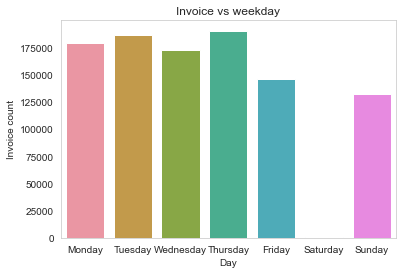

In [10]:
#Plot 2: Count of Invoice per day
plot2 = pd.DataFrame(data.groupby(['weekday'])['Invoice'].count())
plot2 = plot2.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']).reset_index()
sns.set_palette("husl")
ax = sns.barplot(x="weekday", y="Invoice", data = plot2)
plt.grid(False)
plt.title('Invoice vs weekday')
plt.xlabel('Day')
plt.ylabel('Invoice count')

### Plots of Revenue vs Date

In [ ]:
plot3 = pd.DataFrame(data.groupby(['m_y'])['Final_Price'].sum()).reset_index()
#The highest sales are also during the November, as the number of purchasing is the highest.
ax = sns.lineplot(x = 'm_y', y='Final_Price', data = plot3)
plt.xticks(rotation=45)
plt.grid(False)
plt.title('Price vs Month')
plt.xlabel('Month year')
plt.ylabel('Final_Price')
plt.show()

In [12]:
(data['Country'].value_counts()/data.shape[0]).head()

United Kingdom    0.918768
EIRE              0.017019
Germany           0.016303
France            0.013532
Netherlands       0.005045
Name: Country, dtype: float64

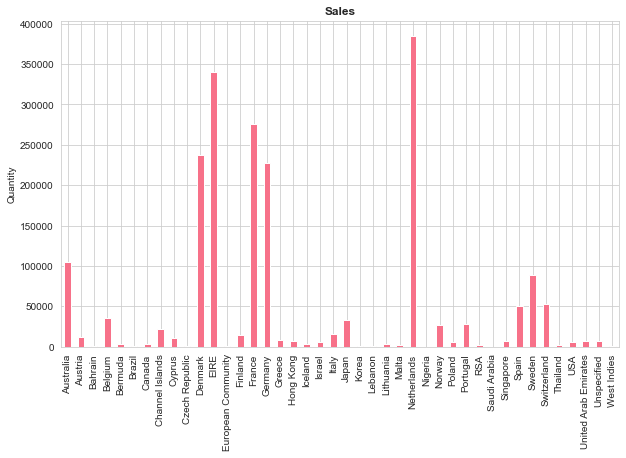

In [20]:
#grouping data by the countries(except UK)
ByCountrySale = Data_Clean[(Data_Clean.Country != 'United Kingdom') & (Data_Clean.Quantity > 0)].groupby('Country')['Quantity'].sum()

#creating the subplot
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
ByCountrySale.plot(kind='bar', ax=ax1).set(ylabel = 'Quantity',xlabel='')
ax1.set_title('Sales', size=12, fontweight = 'bold')
plt.subplots_adjust(hspace = 0.6)
plt.show()

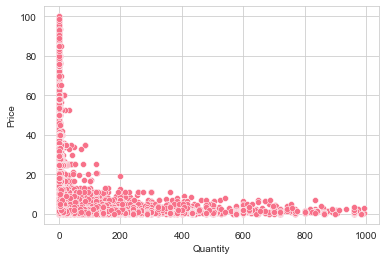

In [21]:
data2 = data[(data['Quantity'] < 1000) & (data['Price']<100)]
#plotting the qunatity vs unitprice
Corr = sns.scatterplot(x="Quantity", y="Price", data = data2)
plt.show()

#as the price of a product increases, the amount of sales of that product would get smaller and customers are more inclined
#to buy products in larger quantities if they have lower prices.

### RFM Analysis

In [22]:
data['date']= pd.to_datetime(data['InvoiceDate'])
print (data['date'].min())
print (data['date'].max())
max_date=data['date'].max()

2009-12-01 07:45:00
2011-12-09 12:50:00


In [23]:
data_rfm=data.groupby(['Customer ID']).agg({'Invoice':'nunique', 
                                            'InvoiceDate':'count',
                                                         'Final_Price':'sum',
                                                         'date':['min','max']})
data_rfm.columns=['count','Frequency','total_cost','min_date','max_date']
data_rfm.head()

,count,Frequency,total_cost,min_date,max_date
Customer ID,,,,,
12346.0,12,34,77556.46,2009-12-14 08:34:00,2011-01-18 10:01:00
12347.0,8,222,4921.53,2010-10-31 14:20:00,2011-12-07 15:52:00
12348.0,5,51,2019.40,2010-09-27 14:59:00,2011-09-25 13:13:00
12349.0,4,175,4428.69,2010-04-29 13:20:00,2011-11-21 09:51:00
12350.0,1,17,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00


In [24]:
data_rfm['Recency']=max_date-data_rfm['max_date']
data_rfm['Recency'] = data_rfm['Recency'].dt.days
data_rfm['days']=max_date-data_rfm['min_date']
data_rfm['days'] = data_rfm['days'].dt.days
data_rfm['Monetary_value']=data_rfm['total_cost']/data_rfm['count']
data_rfm=data_rfm.drop(['count','total_cost','days','min_date','max_date'],axis=1)
data_rfm.head()

,Frequency,Recency,Monetary_value
Customer ID,,,
12346.0,34,325,6463.038333
12347.0,222,1,615.191250
12348.0,51,74,403.880000
12349.0,175,18,1107.172500
12350.0,17,309,334.400000


In [25]:
#4 being the most recent
recency_grps = pd.qcut(data_rfm.Recency, 4,[4,3,2,1])

#4 is the most frequent
freq_grps = pd.qcut(data_rfm.Frequency, 4,[1,2,3,4])

#4 is the high monetary value
mon_grps = pd.qcut(data_rfm.Monetary_value, 4,[1,2,3,4])
#Therefore, customers with R1, F4 and M4 are the best customers

In [26]:
# make a new column for group labels
data_rfm['R'] = recency_grps.values
data_rfm['F'] = freq_grps.values
data_rfm['M'] = mon_grps.values
# sum up the three columns
data_rfm['RFM_Segment'] = data_rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
data_rfm['RFM_Score'] = data_rfm[['R', 'F', 'M']].sum(axis = 1)

data_rfm.head()

,Frequency,Recency,Monetary_value,R,F,M,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
12346.0,34,325,6463.038333,2,2,4,2.02.04.0,8
12347.0,222,1,615.191250,4,4,4,4.04.04.0,12
12348.0,51,74,403.880000,3,2,3,3.02.03.0,8
12349.0,175,18,1107.172500,4,4,4,4.04.04.0,12
12350.0,17,309,334.400000,2,1,3,2.01.03.0,6


Text(0, 0.5, 'Count')

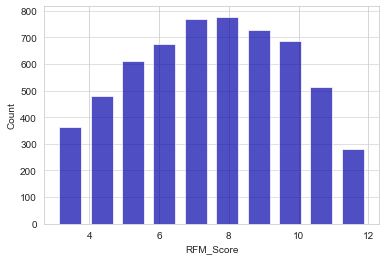

In [27]:
plt.hist(x=data_rfm.RFM_Score, color='#0504aa',
                            alpha=0.7,rwidth=0.70)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('RFM_Score')
plt.ylabel('Count')

In [ ]:
data_rfm.to_pickle('rfm.pkl') 